In [1]:
import numpy as np
from numpy import loadtxt
import fitsio
import healpy as hp
import healsparse as hsp
import skyproj
import matplotlib.pyplot as plt
import Config
from os import listdir
from astropy.table import Table

In [2]:
res = 512

In [3]:
deepCols  = ['KNN_CLASS', 'RA', 'DEC', 'BDF_MAG_DERED_G', 'BDF_MAG_DERED_R', 'MASK_FLAGS', 'MASK_FLAGS_NIR']
deepRA = np.array([])
deepDEC = np.array([])
deepG = np.array([])
deepGR = np.array([])
deepMasks = np.array([])
deepClass = np.array([])
deepFlag = np.array([])
deepFlagNir = np.array([])

for i in (np.arange(5) + 1):
    deepFile = '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_00000' + str(i) + '.fits'

    deepData = fitsio.read(deepFile, columns = deepCols)

    deepRA = np.append(deepRA, deepData['RA'])
    deepDEC = np.append(deepDEC, deepData['DEC'])
    deepG = np.append(deepG, deepData['BDF_MAG_DERED_G'])
    deepGR = np.append(deepGR, deepData['BDF_MAG_DERED_G'] - deepData['BDF_MAG_DERED_R'])
    deepMasks = np.append(deepMasks, deepData['MASK_FLAGS'])
    deepClass = np.append(deepClass, deepData['KNN_CLASS'])
    deepFlag = np.append(deepFlag, deepData['MASK_FLAGS'])
    deepFlagNir = np.append(deepFlagNir, deepData['MASK_FLAGS_NIR'])

cutIndices = np.where((deepMasks == 0) &
                      (deepGR <= 1) &
                      (deepGR >= -0.3) &
                      (deepG <= 25) &
                      (deepG > 24) &
                      (deepRA < 120))[0]# &
                      #(deepClass > 0) &
                      #(deepClass < 3))[0]

deepG = deepG[cutIndices]
deepClass = deepClass[cutIndices]
deepRA = deepRA[cutIndices]
deepDEC = deepDEC[cutIndices]

deepPix = np.sort(np.unique(hp.ang2pix(res, deepRA, deepDEC, lonlat = True, nest = True)))

In [4]:
np.max(deepClass)

2.0

In [5]:
stellarRatio = len(np.where(deepClass == 2)[0]) / len(np.where((deepClass == 1) | (deepClass == 2))[0])

In [6]:
len(np.where(deepClass == 2)[0]) + stellarRatio * len(np.where(deepClass == 0)[0])

2398.1248463935667

In [7]:
np.min((np.where(deepFlag != 0)[0])/(np.where(deepFlagNir != 0)[0]))

1.0

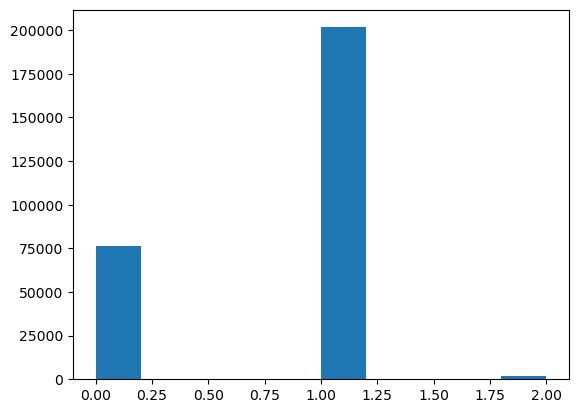

In [8]:
plt.figure(dpi = 100)
plt.hist(deepClass)
plt.show()

# Algorithm for Checks

### 1.)
Look at deep field objects within desired magnitude ranges (for now less than or equal to 24). Done.

###  2.)
Within these objects, only keep those which were given a class (either 1 for galaxy or 2 for star, not 0 for missing bands). Done.

### 3.)
Read in wide field objects, and only look at objects that are in the deep field object list. Match them via separation. THE OBJECTS DO NOT HAVE TO HAVE THE SAME CLASSIFICATION.

### 4.)
Only keep the deep field objects which match location wise with one of these wide field objects, so we should in theory have the same objects, just with one set given their deep field classification, and one set given their wide field classification.

### 5.)
Look at the number of wide field objects called stars vs the number of deep field stars. Then apply multiplicative, magnitude bin corrections and see how the numbers change.

### 6.)
Check if the objects that were given a classification of "Missing Bands" were classified as stars at a higher rate in the wide fields, to see if this is causing a bias.

In [5]:
minGR = -0.3
maxGR = 1
galaDir = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/GalaxyContamination/'
magBins = [20, 22, 23, 24]
pixFile = galaDir + 'Valid_'+str(res)+'_Pixels.fits'
dirStars = '/hdfs/bechtol/balrog/y3/y3a2_gold_v2p2_skim/healpixel/'
files = listdir(dirStars)
usedCols = ['HPIX_4096', 'FLAGS_FOREGROUND', 'FLAGS_BADREGIONS', 'FLAGS_FOOTPRINT', 'EXTENDED_CLASS_SOF', 'SOF_PSF_MAG_G', 'SOF_PSF_MAG_R', 'RA', 'DEC']
validPix = fitsio.read(pixFile)['PIXEL']
pixCheck = np.full(12*(res**2), False, dtype = bool)
pixCheck[validPix] = True

In [6]:
# StarRA = []
# StarDEC = []

# GalaRA = []
# GalaDEC = []

# for i in range(len(magBins)):
    
#     magStarRA = []
#     magStarDEC = []
    
#     magGalaRA = []
#     magGalaDEC = []
    
#     for file in files:
#         obsData = fitsio.read(dirStars + file, columns = usedCols)
#         FOREGROUND = obsData[usedCols[1]]
#         BADREGIONS = obsData[usedCols[2]]
#         FOOTPRINT = obsData[usedCols[3]]
#         CLASS = obsData[usedCols[4]]
#         GMAG = obsData[usedCols[5]]
#         RMAG = obsData[usedCols[6]]
#         RA = obsData[usedCols[7]]
#         DEC = obsData[usedCols[8]]
        
#         if i == 0:
#             magCut = np.where(GMAG <= magBins[i])[0]
#         else:
#             magCut = np.where((GMAG <= magBins[i]) & (GMAG > magBins[i - 1]))[0]
        
#         boolMagCut = np.zeros(len(GMAG))
#         boolMagCut[magCut] = 1
        
#         # Observed Star Objects

#         blueStarCut = np.where((FOREGROUND == 0) & 
#                           (BADREGIONS < 2) & 
#                           (FOOTPRINT == 1) & 
#                           (CLASS <= 1) & 
#                           (CLASS >= 0) &
#                           (boolMagCut > 0) &
#                           ((GMAG - RMAG) <= maxGR) &
#                           ((GMAG - RMAG) >= minGR))[0]
        
#         STARRA = RA[blueStarCut]
#         STARDEC = DEC[blueStarCut]

#         thetaStar, phiStar = hp.pix2ang(4096, obsData[usedCols[0]][blueStarCut], nest = True, lonlat = True)

#         allStarPIX = hp.ang2pix(res, thetaStar, phiStar, nest = True, lonlat = True)

#         STARRA = STARRA[np.where(pixCheck[allStarPIX])[0]]
#         STARDEC = STARDEC[np.where(pixCheck[allStarPIX])[0]]

#         magStarRA.extend(STARRA)
#         magStarDEC.extend(STARDEC)
        
#         # Observed Galaxy Objects
        
#         blueGalaCut = np.where((FOREGROUND == 0) & 
#                           (BADREGIONS < 2) & 
#                           (FOOTPRINT == 1) & 
#                           (CLASS <= 3) & 
#                           (CLASS >= 2) &
#                           (boolMagCut > 0) &
#                           ((GMAG - RMAG) <= maxGR) &
#                           ((GMAG - RMAG) >= minGR))[0]
        
#         GALARA = RA[blueGalaCut]
#         GALADEC = DEC[blueGalaCut]

#         thetaGala, phiGala = hp.pix2ang(4096, obsData[usedCols[0]][blueGalaCut], nest = True, lonlat = True)

#         allGalaPIX = hp.ang2pix(res, thetaGala, phiGala, nest = True, lonlat = True)

#         GALARA = GALARA[np.where(pixCheck[allGalaPIX])[0]]
#         GALADEC = GALADEC[np.where(pixCheck[allGalaPIX])[0]]

#         magGalaRA.extend(GALARA)
#         magGalaDEC.extend(GALADEC)
        
#     StarRA.append(np.array(magStarRA))
#     StarDEC.append(np.array(magStarDEC))
    
#     GalaRA.append(np.array(magGalaRA))
#     GalaDEC.append(np.array(magGalaDEC))
    
# StarRA = np.array(StarRA, dtype = object)
# StarDEC = np.array(StarDEC, dtype = object)

# GalaRA = np.array(GalaRA, dtype = object)
# GalaDEC = np.array(GalaDEC, dtype = object)

In [7]:
starPosFiles = [galaDir + 'Star_Pos_<20.fits', galaDir + 'Star_Pos_20-22.fits', galaDir + 'Star_Pos_22-23.fits',
                 galaDir + 'Star_Pos_23-24.fits']
galaPosFiles = [galaDir + 'Gala_Pos_<20.fits', galaDir + 'Gala_Pos_20-22.fits', galaDir + 'Gala_Pos_22-23.fits',
                 galaDir + 'Gala_Pos_23-24.fits']

In [8]:
# for i in range(len(starPosFiles)):
#     my_table = Table()
#     my_table['RA'] = StarRA[i]
#     my_table['DEC'] = StarDEC[i]
#     my_table.write(starPosFiles[i], overwrite = True)

In [9]:
# for i in range(len(galaPosFiles)):
#     my_table = Table()
#     my_table['RA'] = GalaRA[i]
#     my_table['DEC'] = GalaDEC[i]
#     my_table.write(galaPosFiles[i], overwrite = True)

In [10]:
RARanges = [[5, 15], [35, 40], [50, 55]]
DECRanges = [[-50, -40], [-10, 0], [-30, -25]]

In [11]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [12]:
wideStarRA = []
wideStarDEC = []

for file in starPosFiles:
    magRA = fitsio.read(file)['RA']
    magDEC = fitsio.read(file)['DEC']
    deepCut = np.where(((magRA >= (RARanges[0][0] - 1)) & (magRA <= (RARanges[0][1] + 1)) & 
                        (magDEC >= (DECRanges[0][0] - 1)) & (magDEC <= (DECRanges[0][1] + 1))) | 
                       ((magRA >= (RARanges[1][0] - 1)) & (magRA <= (RARanges[1][1] + 1)) & 
                        (magDEC >= (DECRanges[1][0] - 1)) & (magDEC <= (DECRanges[1][1] + 1))) | 
                       ((magRA >= (RARanges[2][0] - 1)) & (magRA <= (RARanges[2][1] + 1)) & 
                        (magDEC >= (DECRanges[2][0] - 1)) & (magDEC <= (DECRanges[2][1] + 1))))[0]
    wideStarRA.append(magRA[deepCut])
    wideStarDEC.append(magDEC[deepCut])

In [13]:
wideGalaRA = []
wideGalaDEC = []

for file in galaPosFiles:
    magRA = fitsio.read(file)['RA']
    magDEC = fitsio.read(file)['DEC']
    deepCut = np.where(((magRA >= (RARanges[0][0] - 1)) & (magRA <= (RARanges[0][1] + 1)) & 
                        (magDEC >= (DECRanges[0][0] - 1)) & (magDEC <= (DECRanges[0][1] + 1))) | 
                       ((magRA >= (RARanges[1][0] - 1)) & (magRA <= (RARanges[1][1] + 1)) & 
                        (magDEC >= (DECRanges[1][0] - 1)) & (magDEC <= (DECRanges[1][1] + 1))) | 
                       ((magRA >= (RARanges[2][0] - 1)) & (magRA <= (RARanges[2][1] + 1)) & 
                        (magDEC >= (DECRanges[2][0] - 1)) & (magDEC <= (DECRanges[2][1] + 1))))[0]
    wideGalaRA.append(magRA[deepCut])
    wideGalaDEC.append(magDEC[deepCut])

In [14]:
def findMatches(angleCutoff, RASource, DECSource, RAMatchCatalog, DECMatchCatalog):
    c = SkyCoord(ra=RASource*u.degree, dec=DECSource*u.degree)
    catalog = SkyCoord(ra=RAMatchCatalog*u.degree, dec=DECMatchCatalog*u.degree)
    idx, d2d, d3d = c.match_to_catalog_sky(catalog)
    matches = d2d < angleCutoff
    return matches, d2d

In [15]:
matchedStars = []
for i in range(len(wideStarRA)):
    matches, _ = findMatches(0.5*u.arcsec, wideStarRA[i], wideStarDEC[i], deepRA, deepDEC)
    matchedStars.append(matches)

In [16]:
matchedGalas = []
for i in range(len(wideGalaRA)):
    matches, _ = findMatches(0.5*u.arcsec, wideGalaRA[i], wideGalaDEC[i], deepRA, deepDEC)
    matchedGalas.append(matches)

In [17]:
matchStarRA = []
matchStarDEC = []

for i in range(len(matchedStars)):
    matchStarRA.append(wideStarRA[i][matchedStars[i]])
    matchStarDEC.append(wideStarDEC[i][matchedStars[i]])

In [18]:
matchGalaRA = []
matchGalaDEC = []

for i in range(len(matchedGalas)):
    matchGalaRA.append(wideGalaRA[i][matchedGalas[i]])
    matchGalaDEC.append(wideGalaDEC[i][matchedGalas[i]])

In [19]:
deepMatches = []
for i in range(len(matchStarRA)):
    matches, _ = findMatches(0.5*u.arcsec, deepRA, deepDEC, matchStarRA[i], matchStarDEC[i])
    deepMatches.extend(list(np.where(matches)[0]))
for i in range(len(matchGalaRA)):
    matches, _ = findMatches(0.5*u.arcsec, deepRA, deepDEC, matchGalaRA[i], matchGalaDEC[i])
    deepMatches.extend(list(np.where(matches)[0]))
deepMatches = np.array(deepMatches)

deepG = deepG[deepMatches]
deepClass = deepClass[deepMatches]
deepRA = deepRA[deepMatches]
deepDEC = deepDEC[deepMatches]

In [20]:
print(len(deepClass))

14454


In [21]:
deepStars = np.sum(deepClass - 1)
print(deepStars)

1072.0


In [22]:
origStars = []
for i in range(len(matchStarRA)):
    origStars.append(len(matchStarRA[i]))

In [23]:
origGalas = []
for i in range(len(matchGalaRA)):
    origGalas.append(len(matchGalaRA[i]))

In [24]:
corrFiles = [galaDir + 'Star_Correction_<20.fits', galaDir + 'Star_Correction_20-22.fits', 
             galaDir + 'Star_Correction_22-23.fits', galaDir + 'Star_Correction_23-24.fits']

In [25]:
corrPix = []
corrs = []

In [26]:
for file in corrFiles:
    data = fitsio.read(file)
    corrPix.append(data['PIX'])
    corrs.append(data['CORRECTION'])

In [27]:
# overallCorrFile = galaDir + 'Star_Correction_<24.fits'
# overallData = fitsio.read(overallCorrFile)
# overallCorrPix = overallData['PIX']
# overallCorrs = overallData['CORRECTION']

In [28]:
corrStars = []
for i in range(len(matchStarRA)):
    fullCorr = np.full(12*(res**2), hp.UNSEEN)
    fullCorr[corrPix[i]] = corrs[i]
    magPix = hp.ang2pix(res, (0.5*np.pi)-np.deg2rad(matchStarDEC[i]), np.deg2rad(matchStarRA[i]), nest = True, lonlat = True)
    corrStars.append(np.sum(fullCorr[magPix]))

## $g\leq 20$

In [29]:
print(np.sum(deepClass[np.where(deepG <= 20)] - 1))
print(origStars[0])
print(corrStars[0])

168.0
179
171.90366569850002


In [30]:
print(-1 * np.sum(deepClass[np.where(deepG <= 20)] - 2))
print(origGalas[0])

304.0
26


## $20<g\leq 22$

In [31]:
print(np.sum(deepClass[np.where((deepG > 20) & (deepG <= 22))] - 1))
print(origStars[1])
print(corrStars[1])

393.0
461
389.1173296927043


In [32]:
print(-1 * np.sum(deepClass[np.where((deepG > 20) & (deepG <= 22))] - 2))
print(origGalas[1])

1962.0
1098


## $22<g\leq 23$

In [33]:
print(np.sum(deepClass[np.where((deepG > 22) & (deepG <= 23))] - 1))
print(origStars[2])
print(corrStars[2])

255.0
317
206.6018455600887


In [34]:
print(-1 * np.sum(deepClass[np.where((deepG > 22) & (deepG <= 23))] - 2))
print(origGalas[2])

3864.0
2409


## $23<g\leq 24$

In [35]:
print(np.sum(deepClass[np.where((deepG > 23) & (deepG <= 24))] - 1))
print(origStars[3])
print(corrStars[3])

256.0
573
-240.64105461231867


In [36]:
print(-1 * np.sum(deepClass[np.where((deepG > 23) & (deepG <= 24))] - 2))
print(origGalas[3])

7252.0
9390


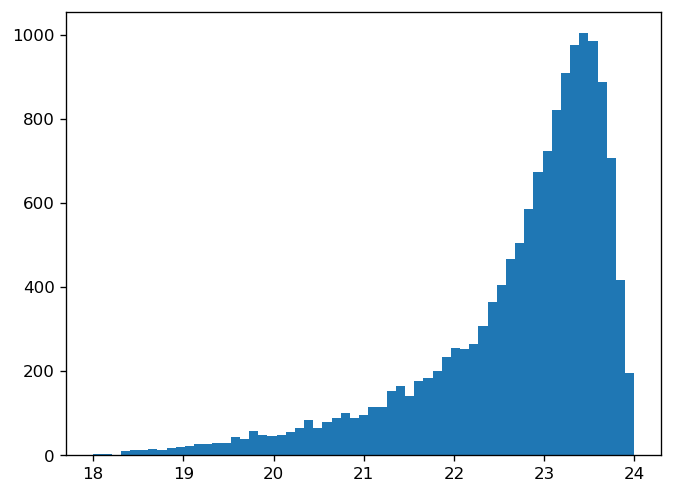

In [37]:
plt.figure(dpi = 120)
plt.hist(deepG, bins = np.linspace(18, 24, 60))
plt.show()